# Programming Project #5: Video Stitching and Processing 

## CS445: Computational Photography - Fall 2019

### Part I: Stitch two key frames <img src="images/project_5/image005.jpg" alt="Drawing" style="float: right; width: 450px"/>

#### This involves:
1. compute homography H between two frames; 
2. project each frame onto the same surface;
3. blend the surfaces.



Check that your homography is correct by plotting four points that form a square in frame 270 and their projections in each image, like this:
<p>
    <img src="images/project_5/image002.jpg" alt="Drawing"/>
    <img src="images/project_5/image004.jpg" alt="Drawing"/>
</p>

In [1]:
# !pip install opencv-python==3.4.2.17
# !pip install opencv-contrib-python==3.4.2.17

import cv2
import numpy as np
from numpy.linalg import svd, inv
import utils
%matplotlib inline
from matplotlib import pyplot as plt
print(cv2.__version__)

3.4.2


In [2]:
# images location
# im1 = './images/input/frames/f0001.jpg'
im1 = './images/input/frames/f0450.jpg'
im2 = './images/input/frames/f0270.jpg'

# Load an color image in grayscale
im1 = cv2.imread(im1)
im2 = cv2.imread(im2)

In [3]:
def auto_homography(Ia,Ib, homography_func=None,normalization_func=None):
    '''
    Computes a homography that maps points from Ia to Ib

    Input: Ia and Ib are images
    Output: H is the homography

    '''
    if Ia.dtype == 'float32' and Ib.dtype == 'float32':
        Ia = (Ia*255).astype(np.uint8)
        Ib = (Ib*255).astype(np.uint8)
    
    Ia_gray = cv2.cvtColor(Ia,cv2.COLOR_BGR2GRAY)
    Ib_gray = cv2.cvtColor(Ib,cv2.COLOR_BGR2GRAY)

    # Initiate SIFT detector
    sift = cv2.xfeatures2d.SIFT_create()
    
    # find the keypoints and descriptors with SIFT
    kp_a, des_a = sift.detectAndCompute(Ia_gray,None)
    kp_b, des_b = sift.detectAndCompute(Ib_gray,None)    
    
    # BFMatcher with default params
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des_a,des_b, k=2)

    # Apply ratio test
    good = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good.append(m)
   
    numMatches = int(len(good))

    matches = good

    # Xa and Xb are 3xN matrices that contain homogeneous coordinates for the N
    # matching points for each image
    Xa = np.ones((3,numMatches))
    Xb = np.ones((3,numMatches))
    
    for idx, match_i in enumerate(matches):
        Xa[:,idx][0:2] = kp_a[match_i.queryIdx].pt
        Xb[:,idx][0:2] = kp_b[match_i.trainIdx].pt

    ## RANSAC
    niter = 1000
    best_score = 0

    for t in range(niter):
        # estimate homography
        subset = np.random.choice(numMatches, 4, replace=False)
        pts1 = Xa[:,subset]
        pts2 = Xb[:,subset]
        
        H_t = homography_func(pts1, pts2, normalization_func) # edit helper code below (computeHomography)

        # score homography
        Xb_ = np.dot(H_t, Xa) # project points from first image to second using H
        du = Xb_[0,:]/Xb_[2,:] - Xb[0,:]/Xb[2,:]
        dv = Xb_[1,:]/Xb_[2,:] - Xb[1,:]/Xb[2,:]

        ok_t = np.sqrt(du**2 + dv**2) < 1  # you may need to play with this threshold
        score_t = sum(ok_t)

        if score_t > best_score:
            best_score = score_t
            H = H_t
            in_idx = ok_t
            pt1 = pts1
            pt2 = pts2
    
    print('best score: {:02f}'.format(best_score))

    # Optionally, you may want to re-estimate H based on inliers

    return H

In [4]:
def computeHomography(pts1, pts2,normalization_func=None):
    '''
    Compute homography that maps from pts1 to pts2 using SVD
     
    Input: pts1 and pts2 are 3xN matrices for N points in homogeneous
    coordinates. 
    
    Output: H is a 3x3 matrix, such that pts2~=H*pts1
    '''
#     print("pts1.shape is ", pts1.shape)
#     print("pts1 is ", pts1)
    N = pts1.shape[1]
    A = np.zeros((2*N, 9))

    for i in range(N):
        x = pts1[:, i]
        xi = pts2[:, i]
        u, v = x[0], x[1]
        ui, vi = xi[0], xi[1]
        A[2*i, :] = np.array([-u, -v, -1, 0, 0, 0, u*ui, v*ui, ui])
        A[2*i+1, :] = np.array([0, 0, 0, -u, -v, -1, u*vi, v*vi, vi])
        
    u, s, vt = np.linalg.svd(A)
    h = vt[vt.shape[0]-1, :]
#     h = vt[:, -1]
    return np.reshape(h, (3,3))
#     raise Exception("TODO in computeHomography() not implemented")


In [5]:
# pt1, pt2, H = auto_homography(im1, im2, computeHomography)
# Computes a homography that maps points from Ia to Ib 
H = auto_homography(im1, im2, computeHomography) #h (450, 270)

best score: 151.000000


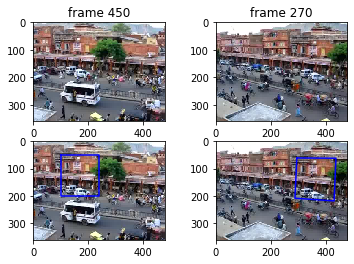

In [6]:
# plot the interest points on im1 and im2 (450)
plotx_im1 = np.array([100, 240, 240, 100, 100])
ploty_im1 = np.array([50, 50, 200, 200, 50])
plotz_im1 = np.ones(5)
plot_im1 = np.array([plotx_im1, ploty_im1, plotz_im1])

plot_im2 = np.dot(H, plot_im1)
plot_im2 = plot_im2 / plot_im2[-1]

fig = plt.figure()
ax1 = fig.add_subplot(221)
plt.imshow(cv2.cvtColor(im1, cv2.COLOR_BGR2RGB))
plt.title('frame 450')

ax2 = fig.add_subplot(222)
plt.imshow(cv2.cvtColor(im2, cv2.COLOR_BGR2RGB))
plt.title('frame 270')

ax3 = fig.add_subplot(223)
plt.imshow(cv2.cvtColor(im1, cv2.COLOR_BGR2RGB))
ax3.plot(plot_im1[0], plot_im1[1], 'b')

ax4 = fig.add_subplot(224)
plt.imshow(cv2.cvtColor(im2, cv2.COLOR_BGR2RGB))
ax4.plot(plot_im2[0], plot_im2[1], 'b')

Text(0.5, 1.0, 'blended')

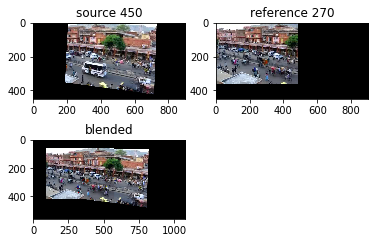

In [44]:
## Example usage of cv2.warpPerspective
## Tips: 
##      1.For reference frame, you may just use identity matrix for the transformation.
##      2.To avoid some pixels being mapped to negative locations, you may want to apply translations first.
# projectedWidth = 1600
# projectedHeight = 500
# projectedSource = cv2.warpPerspective(im1, sourceHomography, (projectedWidth, projectedHeight))
# projectedReference = cv2.warpPerspective(im2, refHomography, (projectedWidth, projectedHeight))

# ## Example usage of utils.blendImages
# blendedOutput = utils.blendImages(projectedSource, projectedReference)
# plt.figure()
# blendedOutput= cv2.cvtColor(blendedOutput, cv2.COLOR_BGR2RGB)
# plt.imshow(blendedOutput)

projectedWidth = 900
projectedHeight = 450

sourceHomography = H
refHomography = np.identity(3)

projectedSource = cv2.warpPerspective(im1, sourceHomography, (projectedWidth, projectedHeight))
projectedReference = cv2.warpPerspective(im2, refHomography, (projectedWidth, projectedHeight))
fig = plt.figure()
ax1 = fig.add_subplot(221)
plt.imshow(cv2.cvtColor(projectedSource, cv2.COLOR_BGR2RGB))
plt.title("source 450")

ax2 = fig.add_subplot(222)
plt.imshow(cv2.cvtColor(projectedReference, cv2.COLOR_BGR2RGB))
plt.title("reference 270")

blendedOutput = utils.blendImages(projectedSource, projectedReference)
canvas_height = 560
canvas_width = 1080
blended_canvas = np.zeros((canvas_height, canvas_width, 3), 'uint8')
img_w = blendedOutput.shape[1]
img_h = blendedOutput.shape[0]

x_offset = int(canvas_height/2 - (img_h/2))
y_offset = int((canvas_width/2)-(img_w/2))

blended_canvas[x_offset:x_offset+blendedOutput.shape[0], y_offset:y_offset+blendedOutput.shape[1]] = blendedOutput
ax3 = fig.add_subplot(223)
plt.imshow(cv2.cvtColor(blended_canvas, cv2.COLOR_BGR2RGB))
plt.title("blended")

### Part II: Panorama using five key frames

In this part you will produce a panorama using five key frames. Let's determine frames [90, 270, 450, 630, 810] as key frames. The goal is to map all the five frames onto the plane corresponding to frame 450 (that we also call the _reference frame_). For the frames 270 and 630 you can follow the instructions in part 1.

<img src="images/project_5/header.jpg" alt="Drawing" style="float: center; width: 500px"/>

Mapping frame 90 to frame 450 is difficult because they share very little area. Therefore you need to perform a two stage mapping by using frame 270 as a guide. Compute one projection from 90 to 270 and one from 270 to 450 and multiply the two matrices. This produces a projection from 90 to 450 even though these frames have very little area in common



In [8]:
import cv2
import numpy as np

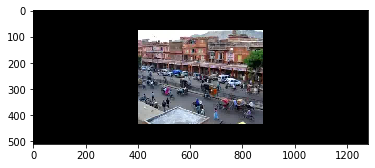

In [48]:
# create a canvas for reference image, by placing reference image in the center of the canvas.
img = cv2.cvtColor(cv2.imread('./images/input/frames/f0450.jpg'), cv2.COLOR_BGR2RGB)
# img = cv2.cvtColor(cv2.imread('./images/input/frames/f0270.jpg'), cv2.COLOR_BGR2RGB)
canvas_height = 510
canvas_width = 1280
reference_450 = np.zeros((canvas_height, canvas_width, 3), 'uint8')
img_w = img.shape[1]
img_h = img.shape[0]

x_offset = int(canvas_height/2 - (img_h/2))
y_offset = int((canvas_width/2)-(img_w/2))
reference_450[x_offset:x_offset+img.shape[0], y_offset:y_offset+img.shape[1]] = img
    
plt.figure()
plt.imshow(reference_450)

In [ ]:

# step 1 project 270 on 450 (Ref)

# step 2 project 90 on (270, 450)

# step 3 project 630 on (90, 270, 450)

# step 4 project 810 (90, 270, 450, 630)

best score: 203.000000


Text(0.5, 1.0, 'warped ')

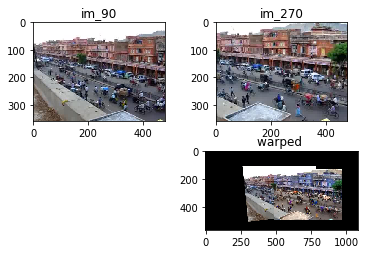

In [49]:
master_frames =[90, 270, 450, 630, 810]
reference_frame = 450
reference_idx = master_frames.index(reference_frame)

projectedWidth = 900
projectedHeight = 450

im_90 = cv2.imread('./images/input/frames/f0090.jpg')
im_270 = cv2.imread('./images/input/frames/f0270.jpg')
im_450 = cv2.imread('./images/input/frames/f0450.jpg')
im_630 = cv2.imread('./images/input/frames/f0630.jpg')
im_810 = cv2.imread('./images/input/frames/f0810.jpg')

H_90 = auto_homography(im_90, reference_450, computeHomography)
sourceHomography = H_90
refHomography = np.identity(3)
projectedSource = cv2.warpPerspective(im_90, H_90, (projectedWidth, projectedHeight))
projectedReference = cv2.warpPerspective(reference_450, refHomography, (projectedWidth, projectedHeight))

blendedOutput = utils.blendImages(projectedSource, projectedReference)
canvas_height = 560
canvas_width = 1080
blended_canvas = np.zeros((canvas_height, canvas_width, 3), 'uint8')
img_w = blendedOutput.shape[1]
img_h = blendedOutput.shape[0]

x_offset = int(canvas_height/2 - (img_h/2))
y_offset = int((canvas_width/2)-(img_w/2))

blended_canvas[x_offset:x_offset+blendedOutput.shape[0], y_offset:y_offset+blendedOutput.shape[1]] = blendedOutput
fig = plt.figure()
ax1 = fig.add_subplot(221)
plt.imshow(cv2.cvtColor(im_90, cv2.COLOR_BGR2RGB))
plt.title('im_90')

ax2 = fig.add_subplot(222)
plt.imshow(cv2.cvtColor(im_270, cv2.COLOR_BGR2RGB))
plt.title('im_270')

# ax3 = fig.add_subplot(223)
# plt.imshow(cv2.cvtColor(im_450, cv2.COLOR_BGR2RGB))
# plt.title('im_450')

ax4 = fig.add_subplot(224)
plt.imshow(cv2.cvtColor(blended_canvas, cv2.COLOR_BGR2RGB))
plt.title("warped ")


# H_270 = auto_homography(im_270, reference_450, computeHomography)
# sourceHomography = H_270
# refHomography = np.identity(3)

# projectedSource = cv2.warpPerspective(im_270, H_270, (projectedWidth, projectedHeight))
# projectedReference = cv2.warpPerspective(reference_450, refHomography, (projectedWidth, projectedHeight))

# blendedOutput = utils.blendImages(projectedSource, projectedReference)
# canvas_height = 560
# canvas_width = 1080
# blended_canvas = np.zeros((canvas_height, canvas_width, 3), 'uint8')
# img_w = blendedOutput.shape[1]
# img_h = blendedOutput.shape[0]

# x_offset = int(canvas_height/2 - (img_h/2))
# y_offset = int((canvas_width/2)-(img_w/2))

# blended_canvas[x_offset:x_offset+blendedOutput.shape[0], y_offset:y_offset+blendedOutput.shape[1]] = blendedOutput
# fig = plt.figure()
# ax1 = fig.add_subplot(221)
# plt.imshow(cv2.cvtColor(im_90, cv2.COLOR_BGR2RGB))
# plt.title('im_90')

# ax2 = fig.add_subplot(222)
# plt.imshow(cv2.cvtColor(im_270, cv2.COLOR_BGR2RGB))
# plt.title('im_270')

# ax3 = fig.add_subplot(223)
# plt.imshow(cv2.cvtColor(im_450, cv2.COLOR_BGR2RGB))
# plt.title('im_450')

# ax4 = fig.add_subplot(224)
# plt.imshow(cv2.cvtColor(blended_canvas, cv2.COLOR_BGR2RGB))
# plt.title("warped ")

### Part 3: Map the video to the reference plane

In [26]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from math import floor

In [38]:
dir_frames = 'images/input/frames'
# dir_frames = 'images/input/30frames'
filenames = []
filesinfo = os.scandir(dir_frames)

In [39]:
filenames = [f.path for f in filesinfo if f.name.endswith(".jpg")]
filenames.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

In [40]:
frameCount = len(filenames)
frameHeight, frameWidth, frameChannels = cv2.imread(filenames[0]).shape
frames = np.zeros((frameCount, frameHeight, frameWidth, frameChannels),dtype=np.float32)

In [41]:
for idx, file_i in enumerate(filenames):
    frames[idx] = cv2.cvtColor(cv2.imread(file_i), cv2.COLOR_BGR2RGB) / 255.0
print(len(frames))

30


In [35]:
## Example usage of utils.projectImage
pastHomographies = np.zeros((len(filenames),len(filenames), 3, 3),dtype=np.float32)
originTranslations = np.zeros((len(filenames), 2), dtype=np.float32)
sourceFrameIndex = 630
referenceFrameIndex = 450

In [42]:
pics = np.zeros((900, 512, 1632, 3), dtype=np.float64)
for i in range(0,450):
    projectedSource, _, originTranslations = utils.imageFolder2mpeg(frames, i, referenceFrameIndex,
                                                            pastHomographies, originTranslations,
                                                            auto_H_func=auto_homography, homography_func=computeHomography, normalization_func=None)
    cv2.imwrite('aligned_frames/a{:04d}.jpg'.format(i), cv2.cvtColor(projectedSource, cv2.COLOR_RGB2BGR))
    pics[i] = projectedSource
    
    
    projectedSource, _, originTranslations = utils.imageFolder2mpeg(frames, 899-i, referenceFrameIndex,
                                                            pastHomographies, originTranslations,
                                                            auto_H_func=auto_homography, homography_func=computeHomography, normalization_func=None)
    cv2.imwrite('aligned_frames/a{:04d}.jpg'.format(899-i), cv2.cvtColor(projectedSource, cv2.COLOR_RGB2BGR))
    pics[899-i] = projectedSource


TypeError: imageFolder2mpeg() got an unexpected keyword argument 'auto_H_func'

### Part 4: Create background panorama

In this part you will remove moving objects from the video and create a background panorama that should incorporate pixels from all the frames.

In the video you produced in __part 3__ each pixel appears in several frames. You need to estimate which of the many colors correspond to the background. We take advantage of the fact that the background color is fixed while the foreground color changes frequently (because foreground moves).

<img src="images/project_5/background.jpg" alt="Drawing" style="float: center; width: 500px"/>


For each pixel in the sequence of __part 3__, determine all valid colors (colors that come from all frames that overlap that pixel). You can experiment with different methods for determining the background color of each pixel, as discussed in class. Perform the same procedure for all pixels and generate output. The output should be a completed panorama showing only pixels of background or non-moving objects.

In [16]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

### Part 5: Create background movie

Map the background panorama to the movie coordinates. For each frame of the movie, say frame 1, you need to estimate a projection from the panorama to frame 1. Note, you should be able to re-use the homographies that you estimated in __Part 3__. Perform this for all frames and generate a movie that looks like the input movie but shows only background pixels. All moving objects that belong to the foreground must be removed.

In [17]:
import os
import cv2
import numpy as np

### Part 6: Create foreground movie

In the background video, moving objects are removed. In each frame, those pixels that are different enough than the background color are considered foreground. For each frame determine foreground pixels and generate a movie that only includes foreground pixels.

In [18]:
import os
import cv2
import numpy as np

## Bells and whistles